In [39]:
import torch
from my_modules.custom_models.classifier_models import ResNet18NPlaned
model = ResNet18NPlaned((4, 256, 256), start_width=64, n_classes=1)
model.load_state_dict(
    torch.load(
        'C:/Users/jdivers/Desktop/Results/fad-nadh-shg-orr/Resnet18/Epochs 250 4-Planed ResNet18.pth', 
        map_location=torch.device('cpu')
    )
)


<All keys matched successfully>

In [40]:
from my_modules.nsclc import NSCLCDataset
data = NSCLCDataset('D:/Paola/JI-Finalized NSCLC Dataset Oct 2024', 
                    ['fad', 'nadh', 'shg', 'orr'],
                    device=torch.device('cpu'), 
                    label='Metastases', 
                    mask_on=True)
data.augment()
data.normalize_method = 'preset'

In [171]:
test_pt = [0, 3, 6, 12, 18, 19, 25, 29]
pt_id = [data.get_patient_ID(pt) for pt in test_pt]
pt_idx = [data.get_patient_subset(pt) for pt in test_pt]
pt_lab = [data.get_patient_label(pt).item() for pt in test_pt]
n_img = [len(pt) for pt in pt_idx]
print('ID\t\tIndex\t# of FOV Images\t\tClass\n')
for id, idx, n, lab in zip(pt_id, test_pt, n_img, pt_lab):
    print(f'{id}\t{idx}\t\t{n//5}\t\t\t\t\t{'Metastatic' if not lab else 'Non-Metastatic'}')

ID		Index	# of FOV Images		Class

S0014	0		6					Metastatic
V0027	3		6					Metastatic
V0142	6		5					Non-Metastatic
S0241	12		6					Non-Metastatic
S0031	18		6					Metastatic
S0093	19		6					Non-Metastatic
V0198	25		8					Non-Metastatic
W0137	29		6					Metastatic


In [75]:
model(torch.unsqueeze(data[pt_idx[0]][0], 0))

TypeError: unsupported operand type(s) for //: 'list' and 'int'

In [84]:
pt_outs = []
model.eval()
with torch.no_grad():
    for i, indices in enumerate(pt_idx):
        out = [model(torch.unsqueeze(data[idx][0], 0)).item() for idx in indices]
        pt_outs.append(out)

In [87]:
import numpy as np
max_pool_out = [max(out) for out in pt_outs]
min_pool_out = [min(out) for out in pt_outs]
mean_out = [np.mean(out) for out in pt_outs]

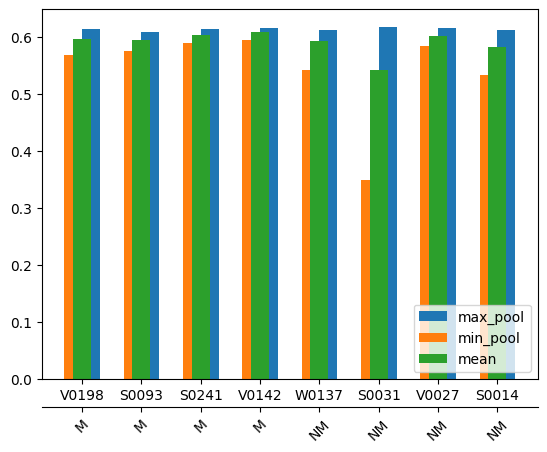

In [154]:
import matplotlib.pyplot as plt
sort_idx = np.argsort(pt_lab)
plt.bar(np.asarray(pt_id)[sort_idx[::-1]], np.asarray(max_pool_out)[sort_idx[::-1]], label='max_pool', align='edge', width=0.3)
plt.bar(np.asarray(pt_id)[sort_idx[::-1]], np.asarray(min_pool_out)[sort_idx[::-1]], label='min_pool', align='edge', width=-0.3)
plt.bar(np.asarray(pt_id)[sort_idx[::-1]], np.asarray(mean_out)[sort_idx[::-1]], label='mean', align='center', width=0.3)
lab_ax = plt.gca().secondary_xaxis(-0.075)
lab_ax.set_ticks(ticks=range(0, 8, 1), labels=['NM' if pt_lab[idx] else 'M' for idx in sort_idx], rotation=45)

plt.legend(loc='lower right')
plt.show()

array([0.349332  , 0.53324139, 0.54161197, 0.56825316, 0.57574403,
       0.58306652, 0.58866441, 0.59520084,        inf])

C:\Users\jdivers\AppData\Local\Temp\ipykernel_6668\1784150123.py:36: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)


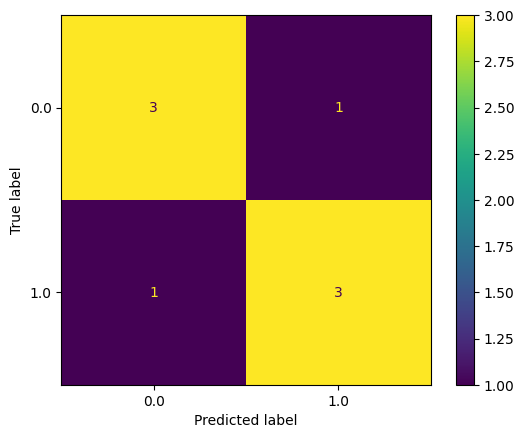

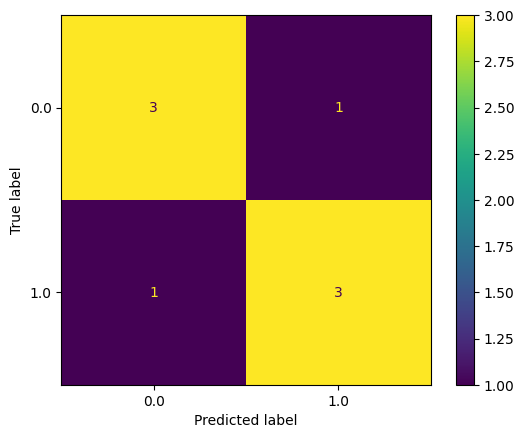

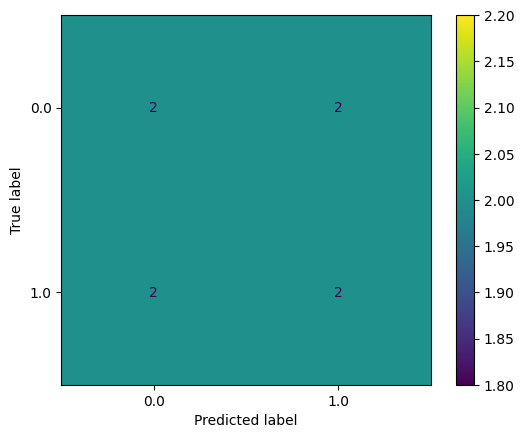

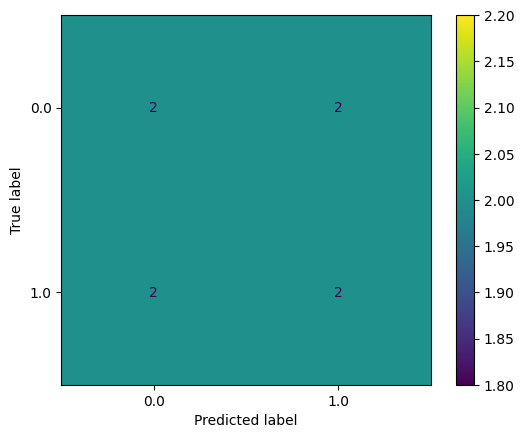

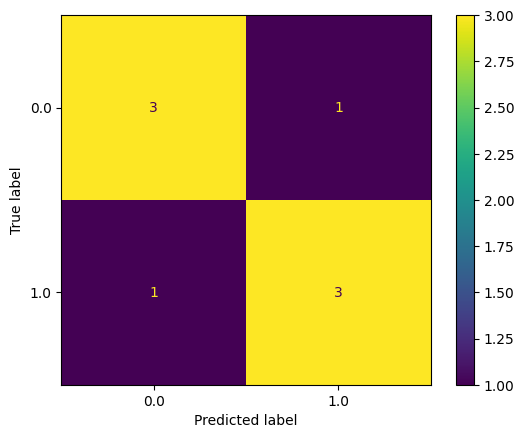

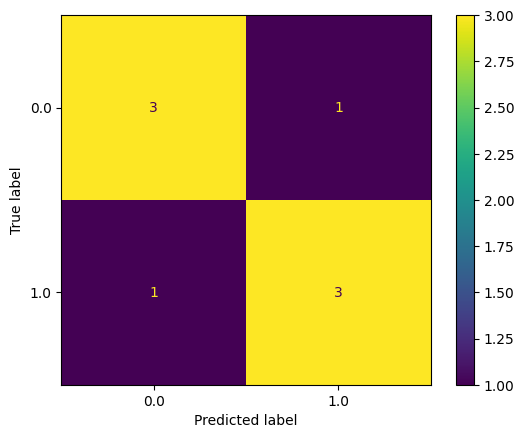

In [275]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, \
    precision_recall_curve, average_precision_score, f1_score, fbeta_score
from matplotlib.lines import Line2D
import pandas as pd

for outs, method in zip([min_pool_out, max_pool_out, mean_out], ['Min (Metastatic) pooling', 'Max (Non-metastatic) pooling', 'Mean']):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(f'Using {method}', fontsize=20)
    
    fpr, tpr, thresholds = roc_curve(pt_lab, outs)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax[0,0])
    ax[0,0].set_title(f'Receiver operating characteristic')
    
    roc_table = pd.DataFrame(data={'Threshold': thresholds, 'FPR': fpr, 'TPR': tpr})
    roc_table.to_csv(f'roc_{method}.csv', index=False)
    
    opt_thresh = thresholds[np.argmax(tpr - fpr)]
    preds = [out > opt_thresh for out in outs]
    ConfusionMatrixDisplay.from_predictions(pt_lab, preds).plot(ax=ax[1,0])
    ax[1,0].set_title('Confusion Matrix at Youden\'s J')
    
    precision, recall, thresholds = precision_recall_curve(pt_lab, outs)
    ap = average_precision_score(pt_lab, outs)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax[0,1])
    pr_auc = auc(recall, precision)
    # ax[2].text(0.7, 0.025, , transform=ax[2].transAxes)
    line = Line2D([0], [0], label=f'AP = {np.nanmax(ap):0.2f}\nAUC = {pr_auc:0.2f}')
    handles = [line]
    ax[0,1].legend(handles=handles, loc='lower right')
    ax[0,1].set_title('Precision Recall Curve')
    
    ax[1,1].axis('off')
    
    thresholds = np.append(thresholds, float('inf'))
    f1 = 2 * (precision * recall) / (precision + recall)
    opt_thresh = thresholds[np.argmax(f1)]
    ax[0,2].plot(thresholds, f1, label=f'Max F1 Score = {np.nanmax(f1):0.2f}')
    ax[0,2].set_title('F1 Score by Threshold')
    ax[0,2].legend(loc='lower right')
    
    ConfusionMatrixDisplay.from_predictions(pt_lab, preds).plot(ax=ax[1,2])
    ax[1,2].set_title('Confusion Matrix at maximum F1 score')
    
    pr_table = pd.DataFrame(data={'Threshold': thresholds, 'Precision': precision, 'Recall': recall, 'F1 Score': f1})
    pr_table.to_csv(f'prf_{method}.csv', index=False)
    
    fig.savefig(f'figures/roc_precrec_f1_confmats_{method}.png')
    plt.close(fig)
    
    